<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 10th exercise: <font color="#C70039">Interpretable Machine Learning by means of Shapley Values</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   29.12.2023
* Student: Ali Ünal

<img src="https://shap.readthedocs.io/en/latest/_images/example_notebooks_overviews_An_introduction_to_explainable_AI_with_Shapley_values_13_0.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Before using Shapley values to explain complicated models, it is helpful to understand how they work for simple models.

In this respect the example in this notebook computes a model for the titanic data set (downloaded from Kaggle) and uses its outputs for explanation of feature importance using SHAP deepexplainer. In addition, several different visualization techniques (plots) for Shapley values are going to be demonstrated. 

For a description of the features please refer to <a href="https://www.kaggle.com/competitions/titanic/data">Kaggle Titanic data set</a>.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.  
---------------------------------

## Imports
Import all necessary python utilities.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import os
import tensorflow as tf
from tensorflow import keras
import ssl
%matplotlib inline
import shap
import warnings 
warnings.filterwarnings('ignore')

## load build-in dataset
take the titanic data set

In [2]:
train_data = pd.read_csv('train.csv', index_col=0)
test_data = pd.read_csv('test.csv', index_col=0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing
Since the titanic data is a raw data set there is a need to preprocess it by dropping unnecessary columns, handling missing data, converting categorical features to numeric features and conducting one-hot encoding.

In [3]:
def data_preprocessing(df):
    
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
    
    # fill na
    df[['Age']] = df[['Age']].fillna(value=df[['Age']].mean())
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())
    df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())
    
    # encode categorical features into numeric
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    # one-hot encoding
    embarked_one_hot = pd.get_dummies(df['Embarked'], prefix='Embarked')
    
    df = df.drop('Embarked', axis=1)
    df = df.join(embarked_one_hot)
    
    return df

# training data processing
train_data = data_preprocessing(train_data)
train_data.isnull().sum()

# create data for training
x_train = train_data.drop(['Survived'], axis=1).values

# Check testing data
test_data.isnull().sum()

# normalize training data
scale = StandardScaler()
x_train = scale.fit_transform(x_train)

# prepare y_train
y_train = train_data['Survived'].values

# preprocess testing data
test_data = data_preprocessing(test_data)
x_test = test_data.values.astype(float)

# normalize testing data
x_test = scale.transform(x_test)

# Check testing data
test_data.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

### Build a simple vanilla ANN, compile and fit the model.

In [4]:
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit model
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
14/14 [==============================] - 0s 1ms/step - loss: 0.6853 - accuracy: 0.5466
Epoch 2/100
14/14 [==============================] - 0s 1ms/step - loss: 0.6317 - accuracy: 0.6521
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 0.5805 - accuracy: 0.7149
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 0.5616 - accuracy: 0.7407
Epoch 5/100
14/14 [==============================] - 0s 1ms/step - loss: 0.5419 - accuracy: 0.7643
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 0.5275 - accuracy: 0.7553
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 0.5334 - accuracy: 0.7677
Epoch 8/100
14/14 [==============================] - 0s 1ms/step - loss: 0.5253 - accuracy: 0.7722
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 0.4829 - accuracy: 0.7991
Epoch 10/100
14/14 [==============================] - 0s 1ms/step - loss: 0.4935 - accuracy: 0.8002
Epoch 11/

### Now, compute the Shapley values

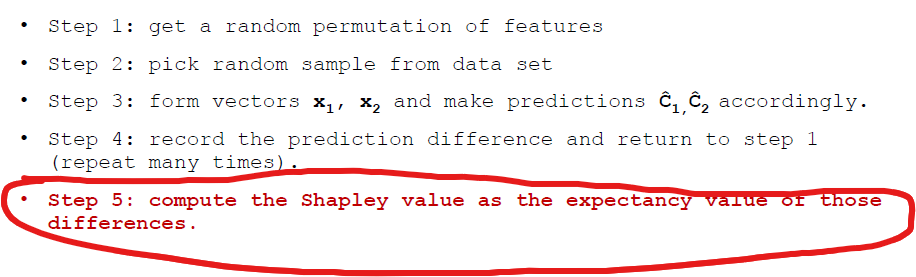

In [5]:
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

### Shapley values interpretation 
#### Global interpretation method

The summary plot shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

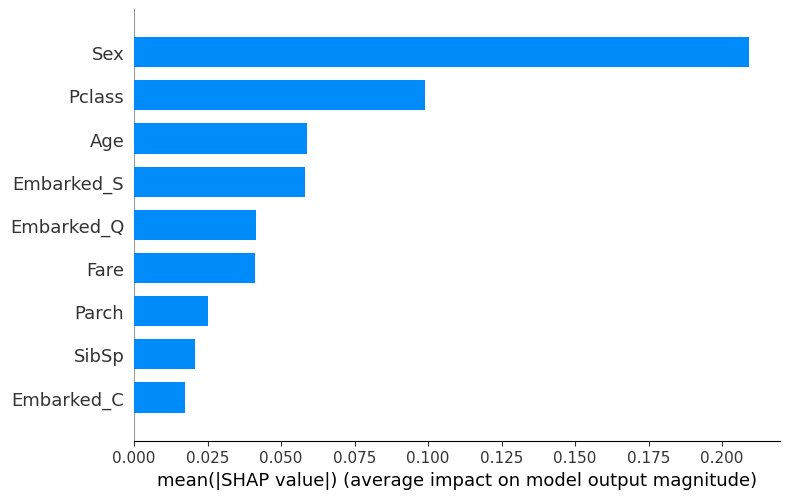

In [6]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test_data.columns)

In [7]:
print(shap_values[0])

[[ 0.0657546   0.16290234  0.02573776 ... -0.0074191   0.12268768
  -0.04335156]
 [ 0.09018001 -0.1799912   0.04689118 ... -0.0066669  -0.00745201
   0.02288543]
 [ 0.00243758  0.18450146  0.11097856 ... -0.00735971  0.09120991
  -0.03314429]
 ...
 [ 0.05132148  0.14556086  0.03692068 ... -0.00746379 -0.00708389
   0.01772846]
 [ 0.04580429  0.1512173   0.00693021 ... -0.00668492 -0.0100273
   0.0223879 ]
 [ 0.05145181  0.1041401   0.01618348 ... -0.01112531 -0.01212578
  -0.03855075]]


#### Local Interpretation methods
##### Force plot
The force plot is great for seeing where the “output value” fits in relation to the “base value”. 
Further, it is possible to observe which features have a positive (red) or negative (blue) impact on the prediction and in addition the magnitude of the impact.

In [8]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.columns)

##### Decision plot
The decision plot enables to observe the amplitude of each change taken by a sample for the values of the displayed features.

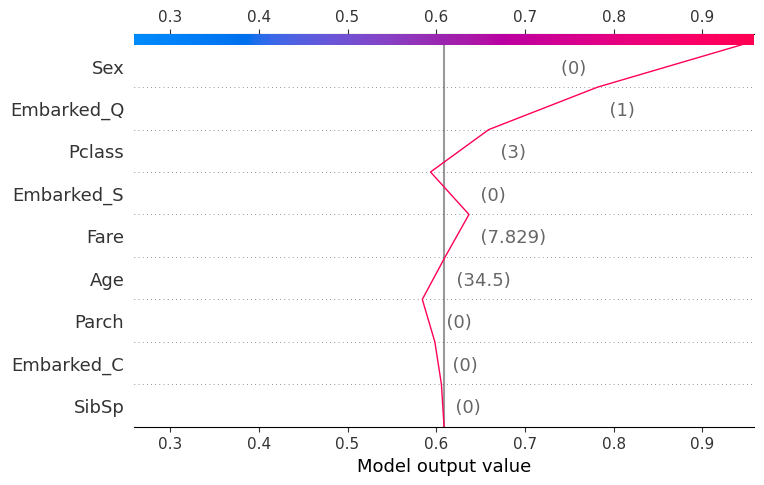

In [9]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.iloc[0,:], 
                   feature_names = test_data.columns.tolist())

##### Waterfall plot
The waterfall plot allows for seeing the amplitude and the nature of the impact of a feature. 
It also allows for seeing the order of importance of the features and the values taken by each feature for the sample.

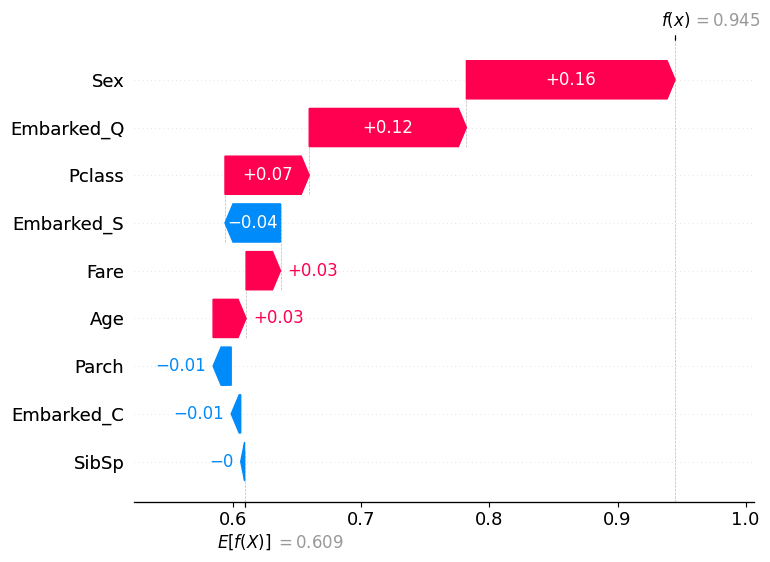

In [10]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], 
                                       feature_names = test_data.columns)

In [11]:
In the waterfall plot, it is evident how the features impact the prediction. Gender ("Sex") has the most substantial contribution to the prediction, followed by Embarked_Q and P Class. The contribution from the rest is minimal.

SyntaxError: invalid syntax (227893604.py, line 1)

In [12]:
from tensorflow.keras import datasets, models, layers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow

In [13]:
# Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images = train_images.reshape((60000, 28, 28, 1)) / 255.0
test_images = test_images.reshape((10000, 28, 28, 1)) / 255.0

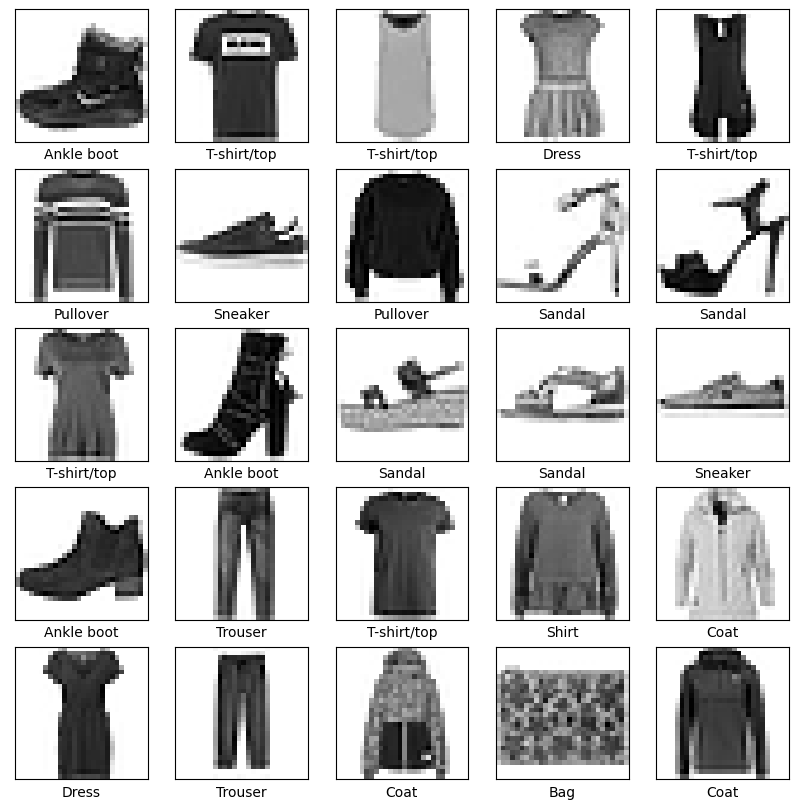

In [14]:
# Define class names for the Fashion MNIST labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# some training images with class names
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels), callbacks=[callback])

Epoch 1/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1128 - accuracy: 0.9575 - val_loss: 0.2851 - val_accuracy: 0.9089
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1023 - accuracy: 0.9617 - val_loss: 0.2988 - val_accuracy: 0.9116
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0933 - accuracy: 0.9644 - val_loss: 0.3306 - val_accuracy: 0.9114
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0837 - accuracy: 0.9685 - val_loss: 0.3491 - val_accuracy: 0.9065
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0793 - accuracy: 0.9697 - val_loss: 0.3307 - val_accuracy: 0.9084
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0719 - accuracy: 0.9725 - val_loss: 0.3517 - val_accuracy: 0.9114


In [18]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

313/313 - 1s - loss: 0.3517 - accuracy: 0.9114 - 770ms/epoch - 2ms/step


In [19]:
num_images = 10
subset_test_images = test_images[:num_images]
predictions = model.predict(subset_test_images)
predicted_class = np.argmax(predictions, axis=1)

def plot_actual_predicted(images, actual_labels, pred_classes):
    fig, axes = plt.subplots(1, len(images) + 1, figsize=(16, 15))
    axes = axes.flatten()

    # plot base reference
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("Base reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')

    # plot images with actual and predicted labels
    for i in range(len(images)):
        ax = axes[i + 1]
        ax.imshow(images[i].reshape(28, 28), cmap=plt.cm.binary)
        actual_label_index = actual_labels[i]
        predicted_label_index = pred_classes[i]
        ax.set_title(f"True: {class_names[actual_label_index]}\nPredict: {class_names[predicted_label_index]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()


# select a set of background examples to take an expectation over
background = train_images[np.random.choice(train_images.shape[0], 100, replace=False)]

# Explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images[0:10])

1/1 [==============================] - 0s 59ms/step


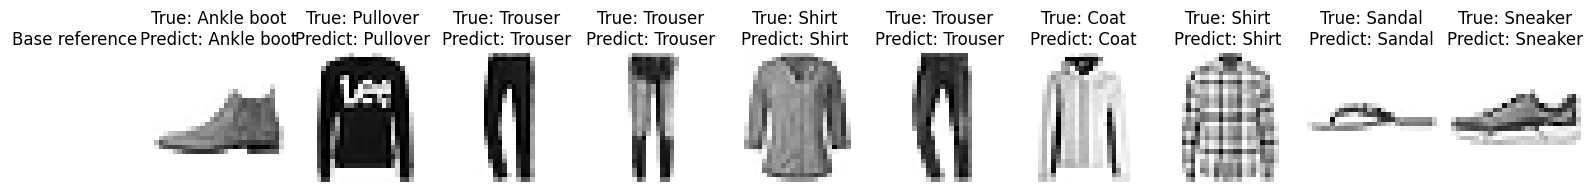

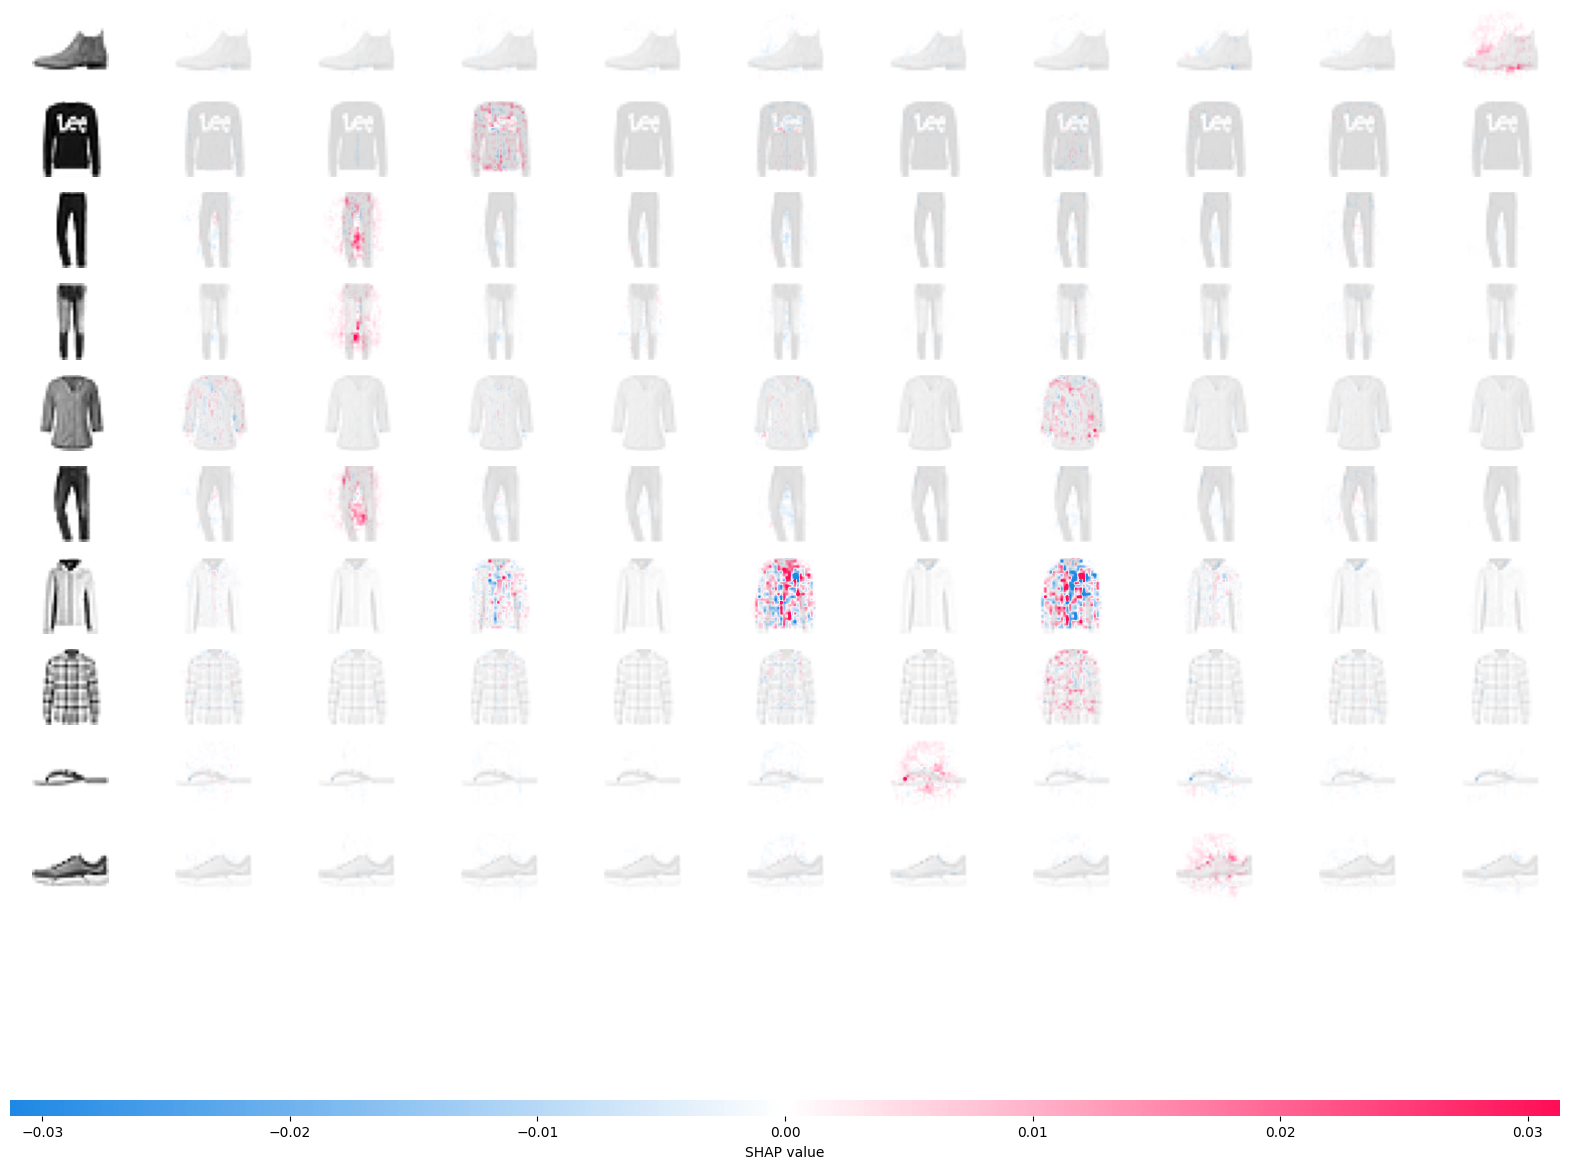

In [20]:
plot_actual_predicted(subset_test_images, test_labels[:num_images].flatten(), predicted_class)
shap.image_plot(shap_values, -test_images[0:10])

Red pixels: positive SHAP values that contributed to classifying that image as that particular class.
Blue pixels: negative SHAP values that contributed to not classifying that image as that particular class.